In [1]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 
# from models import DailyStats
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import pandas as pd
import numpy as np
import datetime


from sklearn.pipeline         import Pipeline
from sklearn.compose         import ColumnTransformer
from sklearn.impute          import SimpleImputer
from sklearn.preprocessing   import StandardScaler, OneHotEncoder, OrdinalEncoder
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, SimpleRNN, Dense, Dropout, LSTM, GRU, BatchNormalization
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.losses import Huber

from feature_engineering import _prepare_training_frame, drop_outliers
from pipeline import _build_pipeline




load_dotenv()  # reads .env in working directory
db_url = os.getenv("DATABASE_URL")
db_url = "postgres://u76gs2mfn3l2um:p1577d0e7a90ab74ce0a8dcbd5dab809f4240ab92836929df08e328b6c82c5a13@c2hbg00ac72j9d.cluster-czrs8kj4isg7.us-east-1.rds.amazonaws.com:5432/d35v2smh8r48et"
print(db_url)
# Heroku uses postgres:// but SQLAlchemy expects postgresql://
if db_url.startswith("postgres://"):
    db_url = db_url.replace("postgres://", "postgresql://", 1)

engine = create_engine(db_url)
best = 100000000

postgres://u76gs2mfn3l2um:p1577d0e7a90ab74ce0a8dcbd5dab809f4240ab92836929df08e328b6c82c5a13@c2hbg00ac72j9d.cluster-czrs8kj4isg7.us-east-1.rds.amazonaws.com:5432/d35v2smh8r48et


In [50]:
def winsorize_series(s, lo=1.0, hi=99.0):
    lo_v, hi_v = np.percentile(s, [lo, hi])
    return np.clip(s, lo_v, hi_v)

In [82]:
# — read & prep
df_daily = pd.read_sql("SELECT * FROM daily_stats;", con=engine)
df_daily['raw_tags'] = df_daily['tags'].apply(lambda x: x if isinstance(x, list) else [])

df_clean, features, hist_cols = _prepare_training_frame(df_daily)

# match the cleaning in your "full pipeline" example
# df_clean = df_clean.dropna()
df_clean = drop_outliers(
    df_clean,
    # cols=['total_subscriptions', 'avg_concurrent_viewers', 'net_follower_change'],
    cols=['total_subscriptions'],
    # cols=['avg_concurrent_viewers'],
    method='iqr',
    factor=2.0
)
# df_clean['total_subscriptions'] = winsorize_series(df_clean['total_subscriptions'], lo=1, hi=99)
# df_clean['net_follower_change'] = winsorize_series(df_clean['net_follower_change'], lo=1, hi=99)

# stable ordering (not required for the split, but nice to keep)
df_clean = df_clean.sort_values(['stream_name', 'stream_date']).reset_index(drop=True)

# build pipeline and grab ONLY the preprocessor
full_pipe, model_type = _build_pipeline(df_clean[features])
pre: pd.DataFrame = full_pipe.named_steps['pre']
# ─────────────────────────────────────────────────────────────────────────────
# 1) Preprocess (fit on train only, per-stream 80% split by time)
# ─────────────────────────────────────────────────────────────────────────────
df_sorted = df_clean.sort_values(['stream_name','stream_date']).reset_index(drop=True)

# per-stream split point (80%)
split_points = {name: int(0.8*len(g)) for name, g in df_sorted.groupby('stream_name', sort=False)}

row_is_train = np.zeros(len(df_sorted), dtype=bool)
for name, g in df_sorted.groupby('stream_name', sort=False):
    ntr = split_points[name]
    row_is_train[g.index[:ntr]] = True

# fit preprocessor on TRAIN rows only
pre = full_pipe.named_steps['pre']
pre.fit(df_sorted.loc[row_is_train, features])

# transform ALL rows with train-fitted preprocessor
def _to_dense(X):
    return X.toarray() if hasattr(X, "toarray") else np.asarray(X)

# —— Guarantee a test set for sequence windows ——
def _make_split_points_with_test(df_sorted, timesteps, start_ratio=0.80, min_ratio=0.60, step=0.05):
    """
    Returns split_points[name] = ntr (row count for train per stream) such that
    at least one test window can be formed across the dataset, if feasible.
    """
    # Try progressively smaller train ratios until at least one test window exists
    ratio = start_ratio
    while ratio >= min_ratio:
        split_points = {}
        total_test_windows = 0

        for name, g in df_sorted.groupby('stream_name', sort=False):
            n = len(g)

            if n < timesteps:
                # Not enough rows for any window; all train, no test here
                split_points[name] = n
                continue

            # Base split from ratio
            ntr = int(ratio * n)

            # Ensure at least ONE test window: need ntr <= (n - timesteps)
            ntr = min(ntr, n - timesteps)

            # If the stream is long enough to have at least one train window too,
            # ensure ntr >= timesteps
            if n >= 2 * timesteps:
                ntr = max(ntr, timesteps)

            # Clamp
            ntr = max(0, min(n, ntr))
            split_points[name] = ntr

            # Count how many test windows this split would yield
            last_start_test = n - timesteps
            if last_start_test >= ntr:
                total_test_windows += (last_start_test - ntr + 1)

        if total_test_windows > 0:
            return split_points  # success with this ratio

        ratio -= step

    # Last resort: force a split that guarantees test windows if n >= timesteps
    # (may sacrifice train windows on very short streams)
    split_points = {}
    for name, g in df_sorted.groupby('stream_name', sort=False):
        n = len(g)
        split_points[name] = max(0, n - timesteps)  # ensures last_start_test >= ntr
    return split_points

timesteps = 1


# —— 1) Build robust split points (guarantee at least one test window overall) ——
split_points = _make_split_points_with_test(df_sorted, timesteps=timesteps)

# Your existing transforms
X_all = _to_dense(pre.transform(df_sorted[features])).astype(np.float32)
y_all = df_sorted['total_subscriptions'].values.astype(np.float32)
# y_all = df_sorted['avg_concurrent_viewers'].values.astype(np.float32)
# y_all = df_sorted['net_follower_change'].values.astype(np.float32)

# from sklearn.preprocessing import StandardScaler

# scaler_y = StandardScaler()
# y_all = scaler_y.fit_transform(y_all.reshape(-1, 1)).astype(np.float32)

# —— 2) Sequence builder (unchanged) ——


X_train_seq, y_train_seq = [], []
X_test_seq,  y_test_seq  = [], []

for name, g in df_sorted.groupby('stream_name', sort=False):
    idx = g.index.to_numpy()
    n   = len(idx)
    ntr = split_points[name]

    # TRAIN windows: start in [0, ntr - timesteps]
    last_start_train = ntr - timesteps
    if last_start_train >= 0:
        for start in range(0, last_start_train + 1):
            sl = idx[start:start+timesteps]
            X_train_seq.append(X_all[sl, :])
            y_train_seq.append(y_all[sl[-1]])

    # TEST windows: start in [ntr, n - timesteps]
    last_start_test = n - timesteps
    if last_start_test >= ntr:
        for start in range(ntr, last_start_test + 1):
            sl = idx[start:start+timesteps]
            X_test_seq.append(X_all[sl, :])
            y_test_seq.append(y_all[sl[-1]])

# stack to arrays
X_train = np.stack(X_train_seq) if X_train_seq else np.empty((0, timesteps, X_all.shape[1]), dtype=np.float32)
y_train = np.asarray(y_train_seq, dtype=np.float32)

X_test  = np.stack(X_test_seq)  if X_test_seq  else np.empty((0, timesteps, X_all.shape[1]), dtype=np.float32)
y_test  = np.asarray(y_test_seq, dtype=np.float32)


print('X_train shape', X_train.shape)
print('X_test shape', X_test.shape)

# (optional) assert we actually have a test set now
if len(X_test) == 0:
    raise RuntimeError("No test windows could be formed. Consider lowering timesteps or widening the test split.")

timesteps     = X_train.shape[1]   # e.g. 10
n_features    = X_train.shape[2]
rnn_units     = 16
dense_units   = 16
learning_rate = 1e-2
drop_rate     = 0.5


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# 2) Instantiate the TensorBoard callback
tensorboard_cb = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,       # record layer activations & weight histograms each epoch
    write_graph=True,       # visualize the graph
    write_images=False      # set True to log model weights as images
)
# ——— Callbacks ———
callbacks = [
    tensorboard_cb,
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]


/Users/christopherclark/Library/Mobile Documents/com~apple~CloudDocs/_Chris_Docs/Coding/darksharkml/feature_engineering.py:154: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["stream_start_time"] = pd.to_datetime(
/Users/christopherclark/Library/Mobile Documents/com~apple~CloudDocs/_Chris_Docs/Coding/darksharkml/feature_engineering.py:169: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('stream_name', group_keys=False)


X_train shape (368, 1, 438)
X_test shape (108, 1, 438)


In [83]:
# for f in features:
#     print(f)

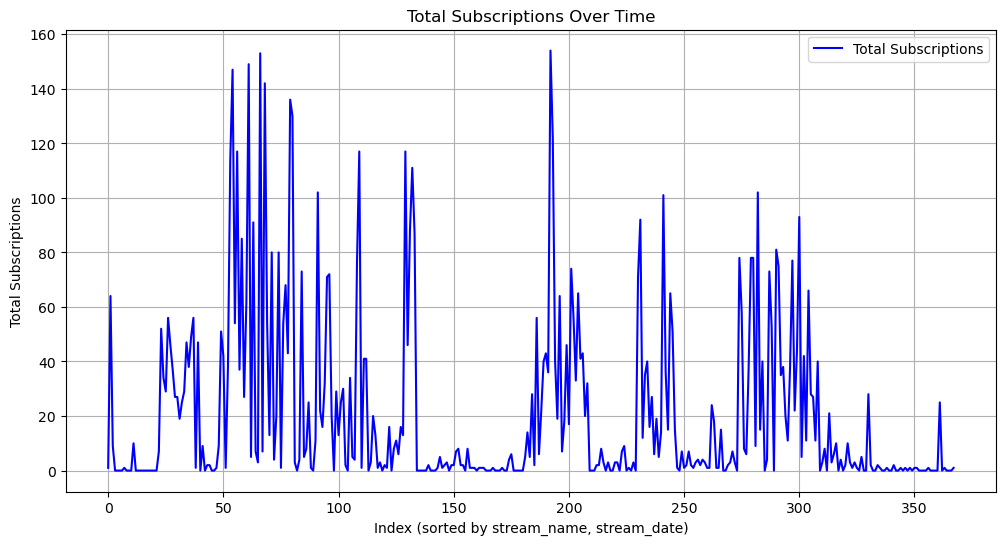

In [84]:
# Plot y_all to visualize the raw target variable distribution

# y_scaler = StandardScaler()
# y_train = y_scaler.fit_transform(np.asarray(y_train).reshape(-1, 1)).ravel()

plt.figure(figsize=(12, 6))
plt.plot(y_train, label="Total Subscriptions", color="blue")
plt.title("Total Subscriptions Over Time")
plt.xlabel("Index (sorted by stream_name, stream_date)")
plt.ylabel("Total Subscriptions")
plt.legend()
plt.grid()
plt.show()

In [101]:
def build_simple_1d_cnn_regression(input_length, num_features):
    model = Sequential([
        # First convolutional block
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(input_length, num_features), padding='same'),
        # MaxPooling1D(pool_size=2),
        Dropout(0.1),

        # Second convolutional block
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        # MaxPooling1D(pool_size=2),
        Dropout(0.1),

        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        # MaxPooling1D(pool_size=2),
        Dropout(0.1),

        # Flatten and dense layers
        Flatten(),
        Dense(16, activation='relu'),
        Dropout(0.3),

        # Output layer — single numeric prediction
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='mse',      # Mean Squared Error for regression
        # loss=tf.keras.losses.Huber(delta=1.0),
        metrics=['mae']  # Mean Absolute Error for monitoring
    )
    return model

# Example usage
input_length = timesteps    # Number of timesteps per sample
num_features = n_features     # Number of features per timestep
model = build_simple_1d_cnn_regression(input_length, num_features)
# model.summary()

/opt/anaconda3/envs/tf-mac/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [102]:
# y_scaler = StandardScaler()
# y_train = y_scaler.fit_transform(np.asarray(y_train).reshape(-1, 1)).ravel()

history = model.fit(
    X_train, y_train,
    validation_split=0.2,   # or (X_val, y_val)
    epochs=200,
    batch_size=32,
    callbacks=callbacks
)

print()
es = next((cb for cb in callbacks if isinstance(cb, tf.keras.callbacks.EarlyStopping)), None)
if es:
    print(f"EarlyStopping best {es.monitor}: {es.best:.6f}")

if es.best < best:
    best = es.best
print("All time best so far:", best)

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 1731.4128 - mae: 23.6780 - val_loss: 395.7060 - val_mae: 9.0412 - learning_rate: 0.0010
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1494.2645 - mae: 21.4912 - val_loss: 360.7212 - val_mae: 9.5404 - learning_rate: 0.0010
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1191.1298 - mae: 20.8980 - val_loss: 354.6784 - val_mae: 12.4904 - learning_rate: 0.0010
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1072.6307 - mae: 23.2589 - val_loss: 349.7285 - val_mae: 13.3013 - learning_rate: 0.0010
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1234.7648 - mae: 24.6719 - val_loss: 281.0401 - val_mae: 10.5097 - learning_rate: 0.0010
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1025.1786 - mae: 20.2425 - val_loss: 250.8134 - val_mae: 9.2900 - learning_rate: 0.0010
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 912.2304 - mae: 18.4785 - val_loss: 221.0705 - va

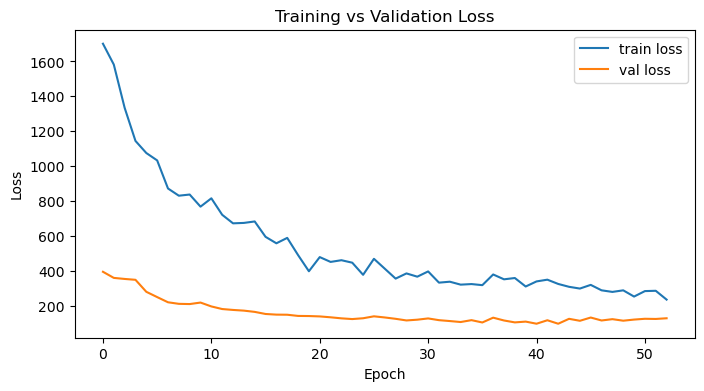

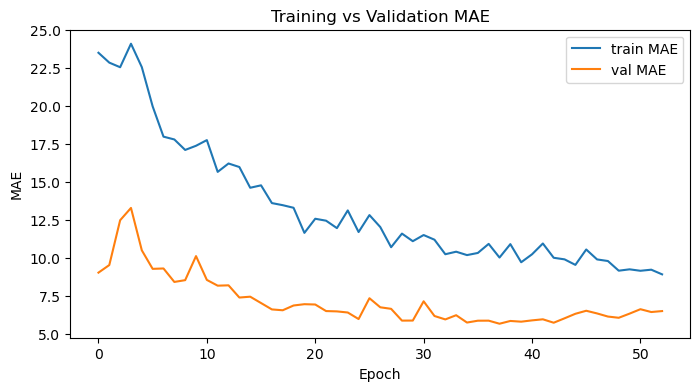

Test MSE: 471.719   Test MAE: 13.101
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


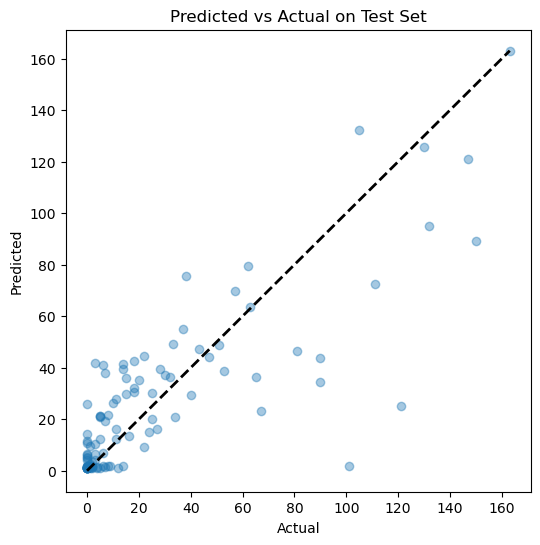

Test MAE:  13.100586891174316
R² = 0.67


In [103]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Plot loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],  label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot MAE
plt.figure(figsize=(8,4))
plt.plot(history.history['mae'],  label='train MAE')
plt.plot(history.history['val_mae'], label='val MAE')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

# ——— 2) Evaluate on your held-out test set ———
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {test_loss:.3f}   Test MAE: {test_mae:.3f}")

# ——— 3) Compare predictions vs ground truth ———
y_pred = model.predict(X_test).ravel()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'k--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual on Test Set")
plt.show()

# ——— 4) Optional: print extra metrics ———
# print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test MAE: ", mean_absolute_error(y_test, y_pred))
print(f"R² = {r2_score(y_test, y_pred):.2f}")


In [112]:
df_legend = df_clean[df_clean['stream_name'] == 'thelegendyagami']
game_categories = df_legend['game_category'].unique()
print(game_categories)
print(len(game_categories))

['street fighter 6' 'hades ii' 'ufo 50' 'donkey kong bananza'
 'guilty as sock!' 'elden ring' 'jackbox party packs' 'blue prince'
 'mega man 11' 'dark souls: remastered' 'the lord of the rings: gollum'
 ' sekiro: shadows die twice']
12


In [ ]:
# — read & prep
df_daily = pd.read_sql("SELECT * FROM daily_stats;", con=engine)
df_daily['raw_tags'] = df_daily['tags'].apply(lambda x: x if isinstance(x, list) else [])

df_clean, features, hist_cols = _prepare_training_frame(df_daily)

# match the cleaning in your "full pipeline" example
# df_clean = df_clean.dropna()
df_clean = drop_outliers(
    df_clean,
    # cols=['total_subscriptions', 'avg_concurrent_viewers', 'net_follower_change'],
    cols=['total_subscriptions'],
    # cols=['avg_concurrent_viewers'],
    method='iqr',
    factor=2.0
)
# df_clean['total_subscriptions'] = winsorize_series(df_clean['total_subscriptions'], lo=1, hi=99)
# df_clean['net_follower_change'] = winsorize_series(df_clean['net_follower_change'], lo=1, hi=99)

# stable ordering (not required for the split, but nice to keep)
df_clean = df_clean.sort_values(['stream_name', 'stream_date']).reset_index(drop=True)

# build pipeline and grab ONLY the preprocessor
full_pipe, model_type = _build_pipeline(df_clean[features])
pre: pd.DataFrame = full_pipe.named_steps['pre']
# ─────────────────────────────────────────────────────────────────────────────
# 1) Preprocess (fit on train only, per-stream 80% split by time)
# ─────────────────────────────────────────────────────────────────────────────
df_sorted = df_clean.sort_values(['stream_name','stream_date']).reset_index(drop=True)

# per-stream split point (80%)
split_points = {name: int(0.8*len(g)) for name, g in df_sorted.groupby('stream_name', sort=False)}

row_is_train = np.zeros(len(df_sorted), dtype=bool)
for name, g in df_sorted.groupby('stream_name', sort=False):
    ntr = split_points[name]
    row_is_train[g.index[:ntr]] = True

# fit preprocessor on TRAIN rows only
pre = full_pipe.named_steps['pre']
pre.fit(df_sorted.loc[row_is_train, features])

# transform ALL rows with train-fitted preprocessor
def _to_dense(X):
    return X.toarray() if hasattr(X, "toarray") else np.asarray(X)

# —— Guarantee a test set for sequence windows ——
def _make_split_points_with_test(df_sorted, timesteps, start_ratio=0.80, min_ratio=0.60, step=0.05):
    """
    Returns split_points[name] = ntr (row count for train per stream) such that
    at least one test window can be formed across the dataset, if feasible.
    """
    # Try progressively smaller train ratios until at least one test window exists
    ratio = start_ratio
    while ratio >= min_ratio:
        split_points = {}
        total_test_windows = 0

        for name, g in df_sorted.groupby('stream_name', sort=False):
            n = len(g)

            if n < timesteps:
                # Not enough rows for any window; all train, no test here
                split_points[name] = n
                continue

            # Base split from ratio
            ntr = int(ratio * n)

            # Ensure at least ONE test window: need ntr <= (n - timesteps)
            ntr = min(ntr, n - timesteps)

            # If the stream is long enough to have at least one train window too,
            # ensure ntr >= timesteps
            if n >= 2 * timesteps:
                ntr = max(ntr, timesteps)

            # Clamp
            ntr = max(0, min(n, ntr))
            split_points[name] = ntr

            # Count how many test windows this split would yield
            last_start_test = n - timesteps
            if last_start_test >= ntr:
                total_test_windows += (last_start_test - ntr + 1)

        if total_test_windows > 0:
            return split_points  # success with this ratio

        ratio -= step

    # Last resort: force a split that guarantees test windows if n >= timesteps
    # (may sacrifice train windows on very short streams)
    split_points = {}
    for name, g in df_sorted.groupby('stream_name', sort=False):
        n = len(g)
        split_points[name] = max(0, n - timesteps)  # ensures last_start_test >= ntr
    return split_points

timesteps = 1


# —— 1) Build robust split points (guarantee at least one test window overall) ——
split_points = _make_split_points_with_test(df_sorted, timesteps=timesteps)

# Your existing transforms
X_all = _to_dense(pre.transform(df_sorted[features])).astype(np.float32)
y_all = df_sorted['total_subscriptions'].values.astype(np.float32)
# y_all = df_sorted['avg_concurrent_viewers'].values.astype(np.float32)
# y_all = df_sorted['net_follower_change'].values.astype(np.float32)

# from sklearn.preprocessing import StandardScaler

# scaler_y = StandardScaler()
# y_all = scaler_y.fit_transform(y_all.reshape(-1, 1)).astype(np.float32)

# —— 2) Sequence builder (unchanged) ——


X_train_seq, y_train_seq = [], []
X_test_seq,  y_test_seq  = [], []

for name, g in df_sorted.groupby('stream_name', sort=False):
    idx = g.index.to_numpy()
    n   = len(idx)
    ntr = split_points[name]

    # TRAIN windows: start in [0, ntr - timesteps]
    last_start_train = ntr - timesteps
    if last_start_train >= 0:
        for start in range(0, last_start_train + 1):
            sl = idx[start:start+timesteps]
            X_train_seq.append(X_all[sl, :])
            y_train_seq.append(y_all[sl[-1]])

    # TEST windows: start in [ntr, n - timesteps]
    last_start_test = n - timesteps
    if last_start_test >= ntr:
        for start in range(ntr, last_start_test + 1):
            sl = idx[start:start+timesteps]
            X_test_seq.append(X_all[sl, :])
            y_test_seq.append(y_all[sl[-1]])

# stack to arrays
X_train = np.stack(X_train_seq) if X_train_seq else np.empty((0, timesteps, X_all.shape[1]), dtype=np.float32)
y_train = np.asarray(y_train_seq, dtype=np.float32)

X_test  = np.stack(X_test_seq)  if X_test_seq  else np.empty((0, timesteps, X_all.shape[1]), dtype=np.float32)
y_test  = np.asarray(y_test_seq, dtype=np.float32)


print('X_train shape', X_train.shape)
print('X_test shape', X_test.shape)

# (optional) assert we actually have a test set now
if len(X_test) == 0:
    raise RuntimeError("No test windows could be formed. Consider lowering timesteps or widening the test split.")

timesteps     = X_train.shape[1]   # e.g. 10
n_features    = X_train.shape[2]
rnn_units     = 16
dense_units   = 16
learning_rate = 1e-2
drop_rate     = 0.5


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# 2) Instantiate the TensorBoard callback
tensorboard_cb = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,       # record layer activations & weight histograms each epoch
    write_graph=True,       # visualize the graph
    write_images=False      # set True to log model weights as images
)
# ——— Callbacks ———
callbacks = [
    tensorboard_cb,
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]


In [ ]:
print(game_categories)
game_cats = np.append(game_categories, game_categories)
print(len(game_cats))

feat_1 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
print('feature 1:', len(feat_1))

labels = [1,   2,   3,   4,   5,   6,   7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
print('labels:', len(labels))

['street fighter 6' 'hades ii' 'ufo 50' 'donkey kong bananza'
 'guilty as sock!' 'elden ring' 'jackbox party packs' 'blue prince'
 'mega man 11' 'dark souls: remastered' 'the lord of the rings: gollum'
 ' sekiro: shadows die twice']
['street fighter 6street fighter 6' 'hades iihades ii' 'ufo 50ufo 50'
 'donkey kong bananzadonkey kong bananza' 'guilty as sock!guilty as sock!'
 'elden ringelden ring' 'jackbox party packsjackbox party packs'
 'blue princeblue prince' 'mega man 11mega man 11'
 'dark souls: remastereddark souls: remastered'
 'the lord of the rings: gollumthe lord of the rings: gollum'
 ' sekiro: shadows die twice sekiro: shadows die twice']
24
feature 1: 24
labels: 24


In [128]:
# pip install xgboost pandas scikit-learn
import numpy as np
import pandas as pd
from xgboost import XGBRanker

# 1) Toy data: each "query_id" is a context (e.g., "tonight 8pm"),
# and each row is a candidate item to rank (e.g., a game/category).
df = pd.DataFrame({
    "query_id":  [1,1,1,1,1,1,1,1,1,1,1,1, 2,2,2,2,2,2,2,2,2,2,2,2],             # 2 queries: sizes 3 and 4
    "game":      game_cats,
    # Example features (replace with your real features)
    "feat1":     feat_1,
    # "feat2":     [10,  30,  5,   7,   9,   25,  18],
    # Relevance/outcome label per (query,item); higher = better (e.g., bucketed revenue)
    "label":     labels,
})

# Ensure rows are grouped by query_id (required for 'group' boundaries)
df = df.sort_values(["query_id"]).reset_index(drop=True)

X = df[["feat1"]].to_numpy(dtype=np.float32)
y = df["label"].to_numpy(dtype=np.float32)

# group = number of items per query, in the same row order
group = df.groupby("query_id").size().to_numpy()

# 2) Train pairwise ranker
ranker = XGBRanker(
    objective="rank:pairwise",
    eval_metric="ndcg@3",     # any ranking metric (used for training eval)
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)
ranker.fit(X, y, group=group)

# 3) Score and rank within each query
df["score"] = ranker.predict(X)

# Top-N per query (e.g., Top-2 recommendations)
top_n = (
    df.assign(rnk=df.groupby("query_id")["score"].rank(ascending=False, method="first"))
      .query("rnk <= 2")
      .sort_values(["query_id","rnk"])
)

print("All scored candidates:\n", df)
print("\nTop-2 per query:\n", top_n[["query_id","game","score","rnk"]])


All scored candidates:
     query_id                           game  feat1  label     score
0          1               street fighter 6      1      1 -4.126747
1          1  the lord of the rings: gollum     11     11  3.400315
2          1         dark souls: remastered     10     10  2.472774
3          1                    mega man 11      9      9  1.672816
4          1                    blue prince      8      8  0.942138
5          1            jackbox party packs      7      7  0.223820
6          1      sekiro: shadows die twice     12     12  3.762412
7          1                guilty as sock!      5      5 -1.209875
8          1            donkey kong bananza      4      4 -1.971638
9          1                         ufo 50      3      3 -2.786614
10         1                       hades ii      2      2 -3.810595
11         1                     elden ring      6      6 -0.481554
12         2         dark souls: remastered     10     10  2.472774
13         2            